In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd

## Load Spectrogram images into a dataset for training

Image Data Path [tf.keras.preprocessing.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) to load the images into tensors. 

This method is doing a lot for us. Lets take a look at a few of the params:
- `labels='inferred'`: The labels are created based on folder directory names.
- `image_size=(256, 256)`: resizes the image
- `validation_split=0.2, subset='validation'`: create validation dataset

In [2]:
train_directory = './data/train/'
test_directory = './data/test/'

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_directory, 
                                                               labels='inferred',
                                                               label_mode='int',
                                                               image_size=(256, 256),
                                                               seed=123, 
                                                               validation_split=0.2,
                                                               subset="training")

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(train_directory, 
                                                               labels='inferred',
                                                               label_mode='int',
                                                               image_size=(256, 256),
                                                               seed=123, 
                                                               validation_split=0.2,
                                                               subset="validation")

test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_directory,
                                                              labels='inferred', 
                                                              label_mode='int', 
                                                              image_size=(256, 256), 
                                                              validation_split=None, 
                                                              subset=None)

class_names = train_ds.class_names
print('Class Names :',class_names)

Found 1332 files belonging to 2 classes.
Using 1066 files for training.
Found 1332 files belonging to 2 classes.
Using 266 files for validation.
Found 668 files belonging to 2 classes.
Class Names : ['no', 'yes']


## Display spectrogram images

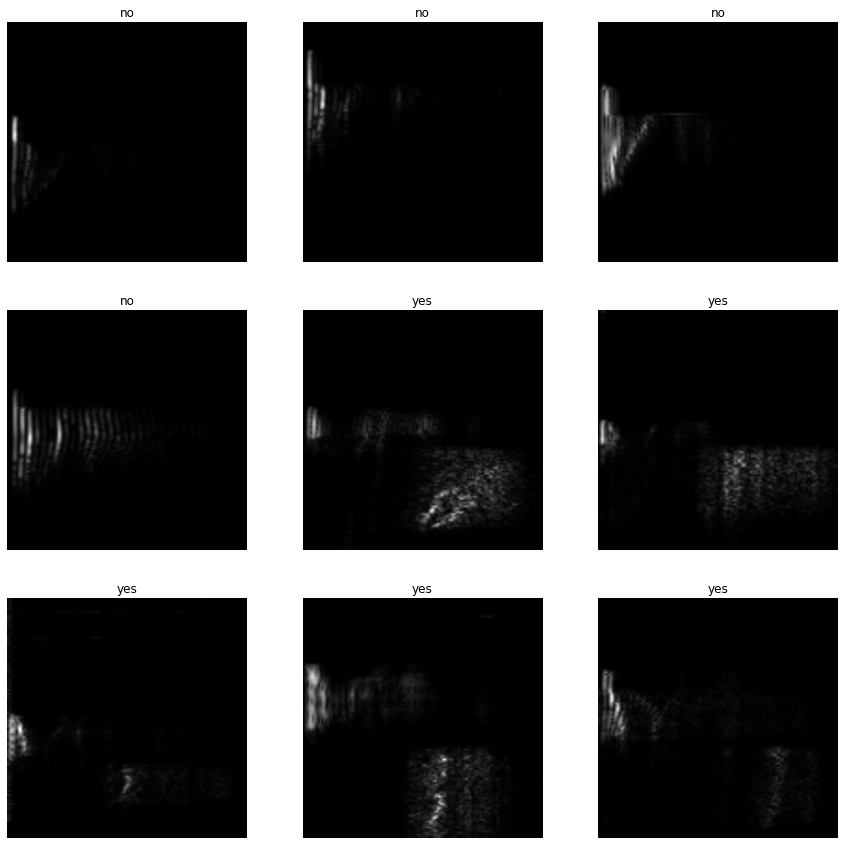

In [4]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Create the model

create the Convolution Neural Network for the computer vision model to process the spectogram images.

To contruct the linear layers we use the [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) and pass in a list with each layer. Read more about the layers [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers).

In [5]:
num_classes = 2
img_height = 256
img_width = 256

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

- Set the `learning_rate`, loss function `loss_fn`, `optimizer` and `metrics`.

In [6]:
learning_rate = 0.125

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['accuracy']
model.compile(optimizer, loss_fn, metrics)

## Train the model

In [7]:
# Set the epocks
epochs = 15
print('Fitting:')

# Train the model.
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting:
Epoch 1/15
34/34 [==============================] - 31s 894ms/step - loss: 0.6460 - accuracy: 0.6538 - val_loss: 0.6367 - val_accuracy: 0.6128
Epoch 2/15
34/34 [==============================] - 30s 867ms/step - loss: 0.5306 - accuracy: 0.7477 - val_loss: 0.5862 - val_accuracy: 0.6617
Epoch 3/15
34/34 [==============================] - 29s 852ms/step - loss: 0.4777 - accuracy: 0.7805 - val_loss: 0.3856 - val_accuracy: 0.8233
Epoch 4/15
34/34 [==============================] - 28s 833ms/step - loss: 0.3361 - accuracy: 0.8546 - val_loss: 0.2173 - val_accuracy: 0.9361
Epoch 5/15
34/34 [==============================] - 30s 891ms/step - loss: 0.2328 - accuracy: 0.9034 - val_loss: 0.5426 - val_accuracy: 0.8120
Epoch 6/15
34/34 [==============================] - 30s 878ms/step - loss: 0.1998 - accuracy: 0.9109 - val_loss: 0.2656 - val_accuracy: 0.8985
Epoch 7/15
34/34 [==============================] - 32s 931ms/step - loss: 0.1094 - accuracy: 0.9625 - val_loss: 0.3584 - val_accurac

## Test the model
Awesome! You should have got somewhere between a 93%-95% accuracy by the 15th epoch. Here we grab a batch from our test data and see how the model performs on the test data.

In [8]:
correct = 0
batch_size = 0
for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    pred = model.predict(X)
    for i in range(batch_size):
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        #print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1
    break

print(f'Number correct: {correct} out of {batch_size}')
print(f'Accuracy {correct / batch_size}')

1/1 [==============================] - 0s 348ms/step
Number correct: 30 out of 32
Accuracy 0.9375


## Test with our own voice

Use an audio file of our own voice saying "yes" or "no" and see if the model predicts correctly. It requires us to add our own audio file, We will need to have the ability to record your voice to a wave format 

First we'll create a `load_audio` function where we set the `sample_rate` to `16000` and the audio `channels` to `1`, load the file, and use `tfio.audio.resample` to resample the audio to the desired rate.

In [110]:
def load_audio(file_path):
    sample_rate = 16000
    channels = 1
    audio_binary = tf.io.read_file(file_path)
    audio, original_sample_rate = tf.audio.decode_wav(audio_binary, 
                                                      desired_samples=sample_rate,
                                                      desired_channels=channels)

    #audio = tfio.audio.resample(audio, original_sample_rate.numpy(), sample_rate)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform, sample_rate

In [112]:
no_waveform, no_sample_rate = load_audio('data/myvoice/no.wav')
yes_waveform, yes_sample_rate = load_audio('data/myvoice/yes.wav')

print(no_waveform.shape)
print(yes_waveform.shape)

(16000,)
(16000,)


- Listen to the audio files now that they have been loaded and resampled.

In [113]:
ipd.Audio(no_waveform.numpy(), rate=16000)

In [105]:
ipd.Audio(yes_waveform.numpy(), rate=16000)

### Spectrogram

In [114]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    print(len(equal_length))
    
    # Create spectrogram with tfio
    spect = tfio.audio.spectrogram(input=equal_length, nfft=255, window=255, stride=128)
    
    # Or create with tf.signal
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    return spectrogram, spect

In [115]:
no_spectrogram, no_spect = get_spectrogram(no_waveform)
yes_spectrogram, yes_spect = get_spectrogram(yes_waveform)

16000
16000


- Create method `plot_spectrogram` to view your voice spectrogram.

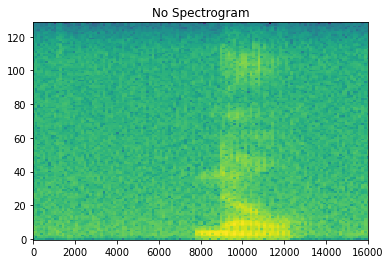

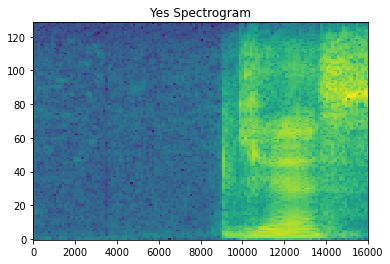

In [116]:
def plot_spectrogram(spectrogram, ax, title):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    ax.set_xlim([0, 16000])
    ax.set_title(title)
    
fig, ax = plt.subplots()  
plot_spectrogram(no_spectrogram.numpy(), ax, 'No Spectrogram')
plt.show()

fig, ax = plt.subplots()  
plot_spectrogram(yes_spectrogram.numpy(), ax, 'Yes Spectrogram')
plt.show()

- Save image to local path.

In [117]:
no_path = './data/myvoice/no_myspec_img.png'
yes_path = './data/myvoice/yes_myspec_img.png'

plt.imsave(no_path, no_spectrogram.numpy(), cmap='gray')
plt.imsave(yes_path, yes_spectrogram.numpy(), cmap='gray')

- Load image to PIL format.

In [118]:
yes_pil_img = tf.keras.preprocessing.image.load_img(yes_path, 
                                                    grayscale=False, 
                                                    color_mode='rgb', 
                                                    target_size=[img_height,img_width],
                                                    interpolation='nearest'
                                                   )

no_pil_img = tf.keras.preprocessing.image.load_img(no_path, 
                                                   grayscale=False, 
                                                   color_mode='rgb', 
                                                   target_size=[img_height,
                                                                img_width],
                                                   interpolation='nearest'
                                                  )

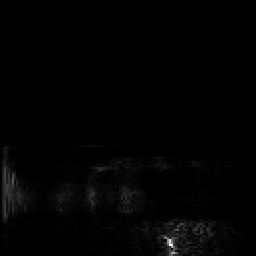

In [119]:
yes_pil_img

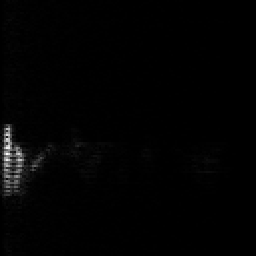

In [120]:
no_pil_img

In [121]:
yes_img_tensor = np.array(yes_pil_img)
no_img_tensor = np.array(no_pil_img)
print(yes_img_tensor.shape)
print(no_img_tensor.shape)

(256, 256, 3)
(256, 256, 3)


In [122]:
yes_pred = model.predict(yes_img_tensor[None,:,:])
no_pred = model.predict(no_img_tensor[None,:,:])

yes_predicted = np.argmax(yes_pred)
yes_string_result = 'yes' if yes_predicted == 1 else 'no'

no_predicted = np.argmax(no_pred)
no_string_result = 'yes' if no_predicted == 1 else 'no'

print(f'Prediction for yes is >>> {yes_string_result}')
print(f'Prediction for no is >>> {no_string_result}')

1/1 [==============================] - 0s 82ms/step
Prediction for yes is >>> yes
Prediction for no is >>> no
